### Importing Dependencies

In [2]:
from __future__ import print_function, division, absolute_import

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import random
import math
from collections import namedtuple, deque

import gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

### Checking Dependencies Version 

In [3]:
sys.version
tf.__version__
gym.__version__
tf.keras.__version__

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

'2.0.0-alpha0'

'0.9.2'

'2.2.4-tf'

### Inspecting the Environment

In [4]:
env = gym.make('CartPole-v1')

I0424 18:11:13.675554 139969222485824 registration.py:117] Making new env: CartPole-v1


In [5]:
env.observation_space.shape[0]
env.action_space.n

4

2

### DQN Algorithm

In [9]:
class DQN:
    def __init__(self,state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.00
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01   
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        self.batch_size = 64
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def build_model(self):
        model = Sequential()
        model.add(Dense(32,input_dim=self.state_size,kernel_initializer="he_uniform",activation="relu"))
        model.add(Dense(24,kernel_initializer="he_uniform",activation="relu"))
        model.add(Dense(self.action_size,activation="linear",kernel_initializer="he_uniform"))
        model.compile(loss="mse",optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon>self.epsilon_min:
                self.epsilon *= self.epsilon_decay
    
    def act(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.choice(np.arange(self.action_size))
        else:
            act_values = self.model.predict(state)[0]
            return np.argmax(act_values)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 
        batch_size = min(self.batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        update_input = np.zeros((batch_size,self.state_size))
        update_target = np.zeros((batch_size,self.state_size))
        action, reward, done = [], [], []
        for i in range(batch_size):
            update_input[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            update_target[i] = minibatch[i][3]
            done.append(minibatch[i][4])
        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)
        for i in range(batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + (self.gamma*np.amax(target_val[i]))
        self.model.fit(update_input, target, epochs = 1, verbose = 0)

In [10]:
if __name__ == "__main__":
    EPISODES = 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQN(state_size, action_size)
    scores = []
    batch_size = 128
    done = False
    for e in range(1, EPISODES+1):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        score = 0
        render_start = False
        render_stop = False
        for time_p in range(500):
            if render_start:
                env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            reward = reward if not done or score == 499 else -100
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            score += reward
                
            state = next_state
            if done:
                agent.update_target_model()
                score = score if score == 500 else score+100
                scores.append(score)
                
                print("Episode: {}/{}, Score: {}, Epsilon: {:.2}".format(e, EPISODES, score, agent.epsilon))
                break
        if render_stop:
            env.close()
        

I0424 18:14:15.012691 139969222485824 registration.py:117] Making new env: CartPole-v1


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 50        
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 24)                792       
______________________________

Episode: 150/500, Score: 500.0, Epsilon: 0.01
Episode: 151/500, Score: 500.0, Epsilon: 0.01
Episode: 152/500, Score: 500.0, Epsilon: 0.01
Episode: 153/500, Score: 500.0, Epsilon: 0.01
Episode: 154/500, Score: 500.0, Epsilon: 0.01
Episode: 155/500, Score: 500.0, Epsilon: 0.01
Episode: 156/500, Score: 500.0, Epsilon: 0.01
Episode: 157/500, Score: 405.0, Epsilon: 0.01
Episode: 158/500, Score: 183.0, Epsilon: 0.01
Episode: 159/500, Score: 500.0, Epsilon: 0.01
Episode: 160/500, Score: 500.0, Epsilon: 0.01
Episode: 161/500, Score: 500.0, Epsilon: 0.01
Episode: 162/500, Score: 500.0, Epsilon: 0.01
Episode: 163/500, Score: 500.0, Epsilon: 0.01
Episode: 164/500, Score: 500.0, Epsilon: 0.01
Episode: 165/500, Score: 500.0, Epsilon: 0.01
Episode: 166/500, Score: 500.0, Epsilon: 0.01
Episode: 167/500, Score: 500.0, Epsilon: 0.01
Episode: 168/500, Score: 500.0, Epsilon: 0.01
Episode: 169/500, Score: 500.0, Epsilon: 0.01
Episode: 170/500, Score: 500.0, Epsilon: 0.01
Episode: 171/500, Score: 500.0, Ep

Episode: 329/500, Score: 245.0, Epsilon: 0.01
Episode: 330/500, Score: 224.0, Epsilon: 0.01
Episode: 331/500, Score: 230.0, Epsilon: 0.01
Episode: 332/500, Score: 219.0, Epsilon: 0.01
Episode: 333/500, Score: 234.0, Epsilon: 0.01
Episode: 334/500, Score: 285.0, Epsilon: 0.01
Episode: 335/500, Score: 226.0, Epsilon: 0.01
Episode: 336/500, Score: 251.0, Epsilon: 0.01
Episode: 337/500, Score: 271.0, Epsilon: 0.01
Episode: 338/500, Score: 270.0, Epsilon: 0.01
Episode: 339/500, Score: 275.0, Epsilon: 0.01
Episode: 340/500, Score: 28.0, Epsilon: 0.01
Episode: 341/500, Score: 8.0, Epsilon: 0.01
Episode: 342/500, Score: 10.0, Epsilon: 0.01
Episode: 343/500, Score: 18.0, Epsilon: 0.01
Episode: 344/500, Score: 10.0, Epsilon: 0.01
Episode: 345/500, Score: 9.0, Epsilon: 0.01
Episode: 346/500, Score: 10.0, Epsilon: 0.01
Episode: 347/500, Score: 9.0, Epsilon: 0.01
Episode: 348/500, Score: 380.0, Epsilon: 0.01
Episode: 349/500, Score: 431.0, Epsilon: 0.01
Episode: 350/500, Score: 450.0, Epsilon: 0.01

In [21]:
iterations = [i for i in range(len(scores))]

### Plotting the performance 

<Figure size 1296x432 with 0 Axes>

Text(0.5, 0, 'Epsiodes')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'DQN Performance on CartPole-v1')

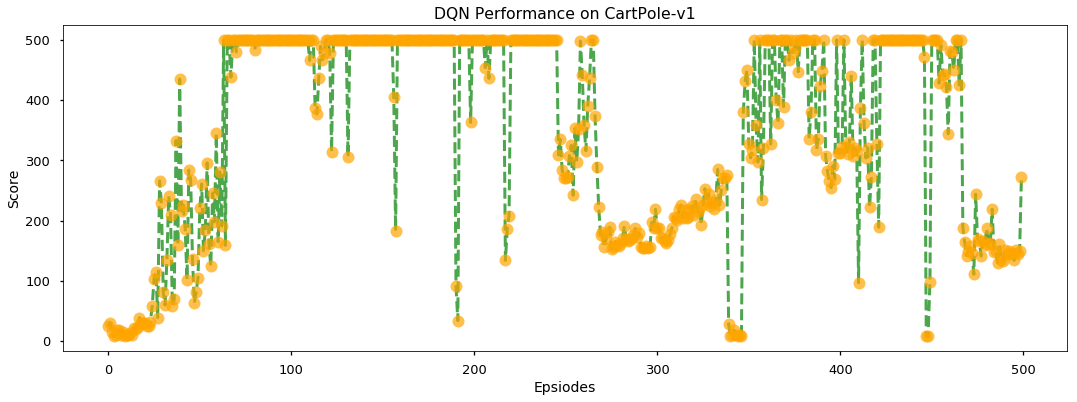

In [37]:
with plt.style.context('seaborn-talk'):
    plt.figure(figsize=(18,6))
    plt.plot(iterations,scores,marker='o',alpha=0.7,linewidth=3,linestyle='--',markersize=12,markerfacecolor='orange',color='g')
    plt.xlabel('Epsiodes',fontsize=14)
    plt.ylabel('Score',fontsize=14)
    plt.title("DQN Performance on CartPole-v1")

In [41]:
agent.model.history.history['loss']

[0.14447633922100067]

###  Reimplementing with loss plotting

In [60]:
class DQN_:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = 0.001
        self.gamma = 0.99
        self.memory = deque(maxlen=2000)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        self.episodes = 500
        self.batch_size = 64
        self.losses = []
    def build_model(self):
        model = Sequential()
        model.add(Dense(64,input_dim=self.state_size,activation="relu",kernel_initializer="he_uniform"))
        model.add(Dense(32,activation="relu",kernel_initializer="he_uniform"))
        model.add(Dense(action_size,activation="linear",kernel_initializer="he_uniform"))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model
    def act(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.choice(np.arange(self.action_size))
        else:
            act_values = self.model.predict(state)[0]
            return np.argmax(act_values)
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state,action,reward,next_state,done))
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
    def replay(self):
        if len(self.memory)<self.batch_size:
            return
        batch_size = min(self.batch_size,len(self.memory))
        minibatch = random.sample(self.memory,batch_size)
        update_input = np.zeros((self.batch_size,self.state_size))
        update_target = np.zeros((self.batch_size,self.state_size))
        action, reward, done = [], [], []
        for i in range(self.batch_size):
            update_input[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            update_target[i] = minibatch[i][3]
            done.append(minibatch[i][4])
        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)
        for i in range(batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * np.amax(target_val[i])
        self.model.fit(update_input, target, epochs = 1, verbose = 0)
        self.losses.append(self.model.history.history['loss'][0])
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [61]:
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQN_(state_size, action_size)
    scores = []
    for e in range(1,agent.episodes+1):
        state = env.reset()
        state = np.reshape(state,[1,state_size])
        score = 0
        render_start = False
        render_stop = False
        for time_p in range(500):
            if render_start:
                env.render()
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state,[1,state_size])
            reward = reward if not done or score == 499 else -100
            agent.remember(state, action, reward, next_state, done)
            score += reward
            agent.replay()
            state = next_state
            if done:
                agent.update_target_model()
                score = score if score == 500 else score + 100
                scores.append(score)
                print("Episode: {}/{}, Score: {}, Epsilon: {:.2}".format(e,agent.episodes,score,agent.epsilon))
                break
        if render_stop:
            env.close()

I0424 20:53:36.518292 139969222485824 registration.py:117] Making new env: CartPole-v1


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_67 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 66        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_70 (Dense)             (None, 32)                2080      
____________________________

Episode: 150/500, Score: 365.0, Epsilon: 0.01
Episode: 151/500, Score: 310.0, Epsilon: 0.01
Episode: 152/500, Score: 353.0, Epsilon: 0.01
Episode: 153/500, Score: 325.0, Epsilon: 0.01
Episode: 154/500, Score: 321.0, Epsilon: 0.01
Episode: 155/500, Score: 334.0, Epsilon: 0.01
Episode: 156/500, Score: 330.0, Epsilon: 0.01
Episode: 157/500, Score: 321.0, Epsilon: 0.01
Episode: 158/500, Score: 339.0, Epsilon: 0.01
Episode: 159/500, Score: 348.0, Epsilon: 0.01
Episode: 160/500, Score: 338.0, Epsilon: 0.01
Episode: 161/500, Score: 344.0, Epsilon: 0.01
Episode: 162/500, Score: 343.0, Epsilon: 0.01
Episode: 163/500, Score: 360.0, Epsilon: 0.01
Episode: 164/500, Score: 409.0, Epsilon: 0.01
Episode: 165/500, Score: 385.0, Epsilon: 0.01
Episode: 166/500, Score: 398.0, Epsilon: 0.01
Episode: 167/500, Score: 408.0, Epsilon: 0.01
Episode: 168/500, Score: 389.0, Epsilon: 0.01
Episode: 169/500, Score: 413.0, Epsilon: 0.01
Episode: 170/500, Score: 399.0, Epsilon: 0.01
Episode: 171/500, Score: 406.0, Ep

Episode: 329/500, Score: 260.0, Epsilon: 0.01
Episode: 330/500, Score: 241.0, Epsilon: 0.01
Episode: 331/500, Score: 224.0, Epsilon: 0.01
Episode: 332/500, Score: 237.0, Epsilon: 0.01
Episode: 333/500, Score: 215.0, Epsilon: 0.01
Episode: 334/500, Score: 245.0, Epsilon: 0.01
Episode: 335/500, Score: 444.0, Epsilon: 0.01
Episode: 336/500, Score: 287.0, Epsilon: 0.01
Episode: 337/500, Score: 369.0, Epsilon: 0.01
Episode: 338/500, Score: 500.0, Epsilon: 0.01
Episode: 339/500, Score: 500.0, Epsilon: 0.01
Episode: 340/500, Score: 268.0, Epsilon: 0.01
Episode: 341/500, Score: 262.0, Epsilon: 0.01
Episode: 342/500, Score: 287.0, Epsilon: 0.01
Episode: 343/500, Score: 246.0, Epsilon: 0.01
Episode: 344/500, Score: 328.0, Epsilon: 0.01
Episode: 345/500, Score: 275.0, Epsilon: 0.01
Episode: 346/500, Score: 305.0, Epsilon: 0.01
Episode: 347/500, Score: 389.0, Epsilon: 0.01
Episode: 348/500, Score: 500.0, Epsilon: 0.01
Episode: 349/500, Score: 500.0, Epsilon: 0.01
Episode: 350/500, Score: 500.0, Ep

In [64]:
loss = agent.losses

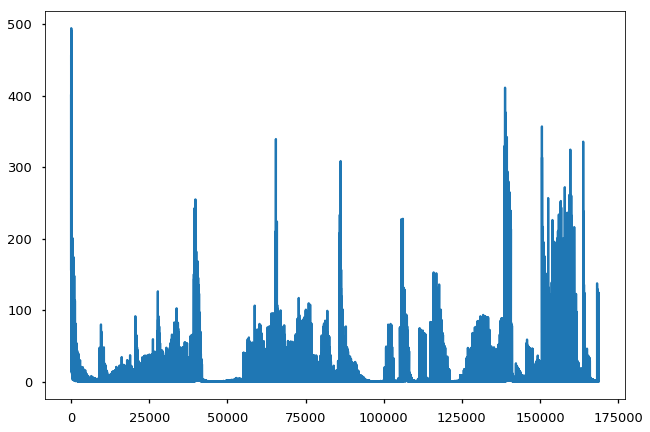

In [70]:
with plt.style.context('seaborn-talk'):
    plt.plot(loss)
    plt.